In [1]:
%reload_ext autotime

import os
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
from scipy import interpolate
from scipy import stats
from datetime import datetime, timedelta
import pytz
from coastsat import SDS_download, SDS_preprocess, SDS_shoreline, SDS_tools, SDS_transects
import geopandas as gpd
import tqdm.auto as tqdm
from glob import glob
import ee
from shapely.ops import split
from shapely import line_merge
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

In [2]:
service_account = 'service-account@iron-dynamics-294100.iam.gserviceaccount.com'
credentials = ee.ServiceAccountCredentials(service_account, '.private-key.json')
ee.Initialize(credentials)

In [8]:
sitename = "nzd0562"
bbox = gpd.read_file("~/CoastSeg/bbox.geojson")
bbox["id"] = sitename
bbox

geometry       id
0  POLYGON ((174.90844 -36.8799, 174.90844 -36.86...  nzd0562

In [14]:
poly = gpd.read_file("polygons.geojson")
pd.concat((poly, bbox)).to_file("polygons.geojson", driver="GeoJSON")

In [44]:
inputs = {
    "polygon": list(bbox.exterior.coords),# list(poly.geometry[sitename].exterior.coords),
    "dates": ['1900-01-01', '2030-12-30'], # All available imagery
    "sat_list": ['L5','L7','L8','L9'],
    "sitename": sitename,
    "filepath": 'data',
    "landsat_collection": 'C02',
}
#result = SDS_download.check_images_available(inputs)

In [45]:
#metadata = SDS_download.retrieve_images(inputs)
metadata = SDS_download.get_metadata(inputs)

In [15]:
shorelines = gpd.read_file("shorelines.geojson")
shorelines

id               area       beach_length             easting  \
0     aus0001  14472901.48412414  16824.52342226356   526589.1754011525   
1     aus0002  53438721.70867591  16794.63203331262   529484.7418874454   
2     aus0003  945965.0455573548   1373.06418305453   535380.0262458471   
3     aus0004  376936.0048626679  253.8720097247056   535397.4773649719   
4     aus0005  1570125.540326883  1830.166677525537   535675.2172291321   
...       ...                ...                ...                 ...   
3141  nzd0317  998611.0209522904  1388.636895098391  -4971829.852334809   
3142  nzd0316  4300057.774234623  4647.035750366853  -4966165.280134064   
3143  nzd0313  22919741.04033367  17378.17283613481   19237414.32246552   
3144  nzd0314  31243633.43084495  17377.03046703852    19254344.2757707   
3145  nzd0561  871003.4889067992  925.5347121883722  -5905869.058151758   

        name            northing  Tide range  median_orientation id_sorted  \
0     noname   7259734.061377056       1.451           92.466545   aus0001   
1     noname   7243833.021796449       1.073           64.603602   aus0002   
2     noname   7237842.578773651       1.074           93.116374   aus0003   
3     noname   7236435.680204276       1.074           79.203813   aus0004   
4     noname   7235101.123683789       1.074           74.946714   aus0005   
...      ...                 ...         ...                 ...       ...   
3141  noname  -4971829.852334809         NaN          309.396745   nzd0556   
3142  noname  -4966165.280134064         NaN          304.531268   nzd0557   
3143  noname  -4939929.050573792         NaN            6.636156   nzd0558   
3144  noname  -4943101.660851713         NaN           15.255119   nzd0559   
3145  noname  -5905869.058151758         NaN          144.851964   nzd0560   

     same_beach  median_slope      ci  n_points  n_points_nonan  \
0          None      0.076702  0.0214     654.0           520.0   
1             1      0.059681  0.0203     579.0           407.0   
2          None      0.041382  0.0112     335.0           243.0   
3          None      0.051540  0.0154     319.0           238.0   
4          None      0.054151  0.0245     307.0           231.5   
...         ...           ...     ...       ...             ...   
3141       None      0.051980  0.0053     397.0           301.0   
3142       None      0.057371  0.0078     363.0           266.0   
3143       None      0.026684  0.0057     324.0           125.0   
3144          1      0.023482  0.0029     340.0           128.5   
3145       None      0.073659  0.0210     411.0           271.0   

                                               geometry  
0     LINESTRING (153.26746 -24.70115, 153.26743 -24...  
1     LINESTRING (153.26189 -24.85277, 153.26191 -24...  
2     LINESTRING (153.35089 -24.96818, 153.35075 -24...  
3     LINESTRING (153.35051 -24.98595, 153.35099 -24...  
4     LINESTRING (153.35161 -24.99115, 153.35228 -24...  
...                                                 ...  
3141  LINESTRING (172.31541 -40.72839, 172.31783 -40...  
3142  LINESTRING (172.36751 -40.69864, 172.3702 -40....  
3143  LINESTRING (172.73493 -40.50746, 172.73502 -40...  
3144  LINESTRING (172.89029 -40.5122, 172.89037 -40....  
3145  LINESTRING (168.53027 -46.77665, 168.53027 -46...  

[3146 rows x 15 columns]

In [20]:
shoreline = gpd.read_file("~/CoastSeg/reference_shoreline.geojson")
shoreline["id"] = sitename
pd.concat((shorelines, shoreline)).to_file("shorelines.geojson", driver="GeoJSON")

In [65]:
# settings for the shoreline extraction
settings = {
    # general parameters:
    'cloud_thresh': 0.1,        # threshold on maximum cloud cover
    'dist_clouds': 300,         # ditance around clouds where shoreline can't be mapped
    'output_epsg': 2193,       # epsg code of spatial reference system desired for the output
    # quality control:
    'check_detection': False,    # if True, shows each shoreline detection to the user for validation
    'adjust_detection': False,  # if True, allows user to adjust the postion of each shoreline by changing the threhold
    'save_figure': False,        # if True, saves a figure showing the mapped shoreline for each image
    # [ONLY FOR ADVANCED USERS] shoreline detection parameters:
    'min_beach_area': 1000,     # minimum area (in metres^2) for an object to be labelled as a beach
    'min_length_sl': 500,       # minimum length (in metres) of shoreline perimeter to be valid
    'cloud_mask_issue': False,  # switch this parameter to True if sand pixels are masked (in black) on many images
    'sand_color': 'latest',    # 'default', 'latest', 'dark' (for grey/black sand beaches) or 'bright' (for white sand beaches)
    'pan_off': False,           # True to switch pansharpening off for Landsat 7/8/9 imagery
    's2cloudless_prob': 40,      # threshold to identify cloud pixels in the s2cloudless probability mask
    # add the inputs defined previously
    'inputs': inputs
}

# [OPTIONAL] preprocess images (cloud masking, pansharpening/down-sampling)
#SDS_preprocess.save_jpg(metadata, settings, use_matplotlib=True)

In [48]:
transects_gdf = gpd.read_file("transects_extended.geojson").drop_duplicates()
transects_gdf.set_index("id", inplace=True)
transects_gdf = transects_gdf[transects_gdf.site_id == sitename]
display(transects_gdf)
transects = {}
for transect_id in transects_gdf.index:
    transects[transect_id] = np.array(transects_gdf.geometry.to_crs(settings["output_epsg"])[transect_id].coords)
transects

site_id  orientation  along_dist  along_dist_norm  beach_slope  \
id                                                                             
nzd0562-0000  nzd0562          NaN         NaN              NaN          0.1   
nzd0562-0001  nzd0562          NaN         NaN              NaN          0.1   
nzd0562-0002  nzd0562          NaN         NaN              NaN          0.1   
nzd0562-0003  nzd0562          NaN         NaN              NaN          0.1   
nzd0562-0004  nzd0562          NaN         NaN              NaN          0.1   
nzd0562-0005  nzd0562          NaN         NaN              NaN          0.1   
nzd0562-0006  nzd0562          NaN         NaN              NaN          0.1   
nzd0562-0007  nzd0562          NaN         NaN              NaN          0.1   
nzd0562-0008  nzd0562          NaN         NaN              NaN          0.1   
nzd0562-0009  nzd0562          NaN         NaN              NaN          0.1   
nzd0562-0010  nzd0562          NaN         NaN              NaN          0.1   
nzd0562-0011  nzd0562          NaN         NaN              NaN          0.1   
nzd0562-0012  nzd0562          NaN         NaN              NaN          0.1   
nzd0562-0013  nzd0562          NaN         NaN              NaN          0.1   
nzd0562-0014  nzd0562          NaN         NaN              NaN          0.1   
nzd0562-0015  nzd0562          NaN         NaN              NaN          0.1   
nzd0562-0016  nzd0562          NaN         NaN              NaN          0.1   
nzd0562-0017  nzd0562          NaN         NaN              NaN          0.1   
nzd0562-0018  nzd0562          NaN         NaN              NaN          0.1   

              cil  ciu     trend  n_points  n_points_nonan  r2_score  \
id                                                                     
nzd0562-0000  NaN  NaN  0.272506     605.0           218.0  0.013036   
nzd0562-0001  NaN  NaN  0.330941     605.0           438.0  0.022484   
nzd0562-0002  NaN  NaN  0.502315     605.0           447.0  0.062842   
nzd0562-0003  NaN  NaN  0.527304     605.0           449.0  0.099683   
nzd0562-0004  NaN  NaN  0.497505     605.0           456.0  0.116301   
nzd0562-0005  NaN  NaN  0.496776     605.0           458.0  0.120213   
nzd0562-0006  NaN  NaN  0.396685     605.0           460.0  0.092203   
nzd0562-0007  NaN  NaN  0.402488     605.0           458.0  0.104469   
nzd0562-0008  NaN  NaN  0.429400     605.0           456.0  0.108413   
nzd0562-0009  NaN  NaN  0.466486     605.0           463.0  0.133484   
nzd0562-0010  NaN  NaN  0.429879     605.0           458.0  0.109618   
nzd0562-0011  NaN  NaN  0.517954     605.0           447.0  0.145057   
nzd0562-0012  NaN  NaN  0.424112     605.0           453.0  0.089791   
nzd0562-0013  NaN  NaN  0.401206     605.0           455.0  0.080360   
nzd0562-0014  NaN  NaN  0.294015     605.0           447.0  0.045865   
nzd0562-0015  NaN  NaN  0.111052     605.0           453.0  0.005716   
nzd0562-0016  NaN  NaN  0.124943     605.0           444.0  0.008540   
nzd0562-0017  NaN  NaN -0.023057     605.0           410.0  0.000192   
nzd0562-0018  NaN  NaN  0.395625     605.0           377.0  0.031522   

                    mae         mse       rmse   intercept  \
id                                                           
nzd0562-0000  14.022238  311.737950  17.656102  242.589961   
nzd0562-0001  11.523003  247.483711  15.731615  222.340202   
nzd0562-0002  10.176908  194.830014  13.958152  226.191002   
nzd0562-0003   8.330010  129.145484  11.364219  209.488961   
nzd0562-0004   7.441567   98.859572   9.942815  200.774508   
nzd0562-0005   7.215061   93.691611   9.679443  199.554645   
nzd0562-0006   6.689388   81.081489   9.004526  202.176206   
nzd0562-0007   6.190294   71.551929   8.458837  204.934913   
nzd0562-0008   6.569006   77.885705   8.825288  206.240202   
nzd0562-0009   6.281849   71.593098   8.461270  199.323906   
nzd0562-0010   6.275574   75.844569   8.708879  196.471536   
nzd0562-0011  

{'nzd0562-0000': array([[1771156.72338293, 5916664.78674575],
        [1771335.60882113, 5917022.55762215]]),
 'nzd0562-0001': array([[1771086.14349435, 5916700.07669004],
        [1771265.02893255, 5917057.84756644]]),
 'nzd0562-0002': array([[1770983.51397321, 5916755.38228784],
        [1771226.49867652, 5917073.12185723]]),
 'nzd0562-0003': array([[1770899.92528121, 5916843.66645877],
        [1771198.33587826, 5917110.03296486]]),
 'nzd0562-0004': array([[1770844.04953608, 5916906.26409805],
        [1771142.46013313, 5917172.63060414]]),
 'nzd0562-0005': array([[1770788.17379095, 5916968.86173733],
        [1771086.584388  , 5917235.22824342]]),
 'nzd0562-0006': array([[1770732.29804582, 5917031.45937661],
        [1771030.70864288, 5917297.8258827 ]]),
 'nzd0562-0007': array([[1770676.4223007 , 5917094.05701589],
        [1770974.83289775, 5917360.42352198]]),
 'nzd0562-0008': array([[1770611.76805428, 5917167.19566836],
        [1770927.73565391, 5917412.48014807]]),
 'nzd0562-

In [50]:
ref_sl = np.array(shoreline.to_crs(2193).geometry[0].coords)
ref_sl

array([[1771246.16610203, 5916843.67218395],
       [1771175.58621345, 5916878.96212824],
       [1771105.00632486, 5916914.25207254],
       [1771049.13057974, 5916976.84971182],
       [1770993.25483461, 5917039.44735109],
       [1770937.37908948, 5917102.04499038],
       [1770881.50334435, 5917164.64262966],
       [1770825.62759922, 5917227.24026893],
       [1770769.75185409, 5917289.83790821],
       [1770714.29622735, 5917372.39117076],
       [1770658.8406006 , 5917454.9444333 ],
       [1770603.38497386, 5917537.49769584],
       [1770547.92934712, 5917620.05095838],
       [1770509.48851494, 5917694.41191242],
       [1770471.04768276, 5917768.77286646],
       [1770432.60685059, 5917843.13382051],
       [1770394.16601841, 5917917.49477455],
       [1770361.39678443, 5917986.81430798],
       [1770328.62755044, 5918056.13384141]])

In [66]:
settings["max_dist_ref"] = 100
settings["reference_shoreline"] = np.flip(ref_sl)

In [68]:
output = SDS_shoreline.extract_shorelines(metadata, settings)
output

L5: Mapping Shorelines:   0%|          | 0/140 [00:00<?, ?it/s]

L7: Mapping Shorelines:   0%|          | 0/793 [00:00<?, ?it/s]

L8: Mapping Shorelines:   0%|          | 0/425 [00:00<?, ?it/s]

L9: Mapping Shorelines:   0%|          | 0/88 [00:00<?, ?it/s]

{'dates': [datetime.datetime(1999, 7, 18, 21, 58, 49, tzinfo=<UTC>),
  datetime.datetime(1999, 8, 26, 22, 4, 44, tzinfo=<UTC>),
  datetime.datetime(1999, 8, 26, 22, 5, 8, tzinfo=<UTC>),
  datetime.datetime(1999, 9, 20, 21, 58, 56, tzinfo=<UTC>),
  datetime.datetime(1999, 9, 27, 22, 4, 48, tzinfo=<UTC>),
  datetime.datetime(1999, 9, 27, 22, 5, 12, tzinfo=<UTC>),
  datetime.datetime(2000, 1, 10, 21, 58, 52, tzinfo=<UTC>),
  datetime.datetime(2000, 2, 11, 21, 58, 45, tzinfo=<UTC>),
  datetime.datetime(2000, 5, 17, 21, 58, 7, tzinfo=<UTC>),
  datetime.datetime(2000, 5, 24, 22, 3, 46, tzinfo=<UTC>),
  datetime.datetime(2000, 5, 24, 22, 4, 10, tzinfo=<UTC>),
  datetime.datetime(2000, 6, 9, 22, 4, 4, tzinfo=<UTC>),
  datetime.datetime(2000, 6, 25, 22, 3, 56, tzinfo=<UTC>),
  datetime.datetime(2000, 7, 11, 22, 3, 17, tzinfo=<UTC>),
  datetime.datetime(2000, 7, 11, 22, 3, 41, tzinfo=<UTC>),
  datetime.datetime(2000, 8, 12, 22, 2, 54, tzinfo=<UTC>),
  datetime.datetime(2000, 8, 12, 22, 3, 18, tz

In [69]:
# Have to flip to get x,y?
output['shorelines'] = [np.flip(s) for s in output['shorelines']]

In [70]:
output = SDS_tools.remove_duplicates(output) # removes duplicates (images taken on the same date by the same satellite)
output = SDS_tools.remove_inaccurate_georef(output, 10) # remove inaccurate georeferencing (set threshold to 10 m)

253 duplicates
0 bad georef


In [71]:
from pyproj import CRS
geomtype = 'lines' # choose 'points' or 'lines' for the layer geometry
gdf = SDS_tools.output_to_gdf(output, geomtype)
if gdf is None:
    raise Exception("output does not contain any mapped shorelines")
gdf.crs = CRS(settings['output_epsg']) # set layer projection
# save GEOJSON layer to file
gdf.to_file(os.path.join(inputs['filepath'], inputs['sitename'], '%s_output_%s.geojson'%(sitename,geomtype)),
                                driver='GeoJSON', encoding='utf-8')

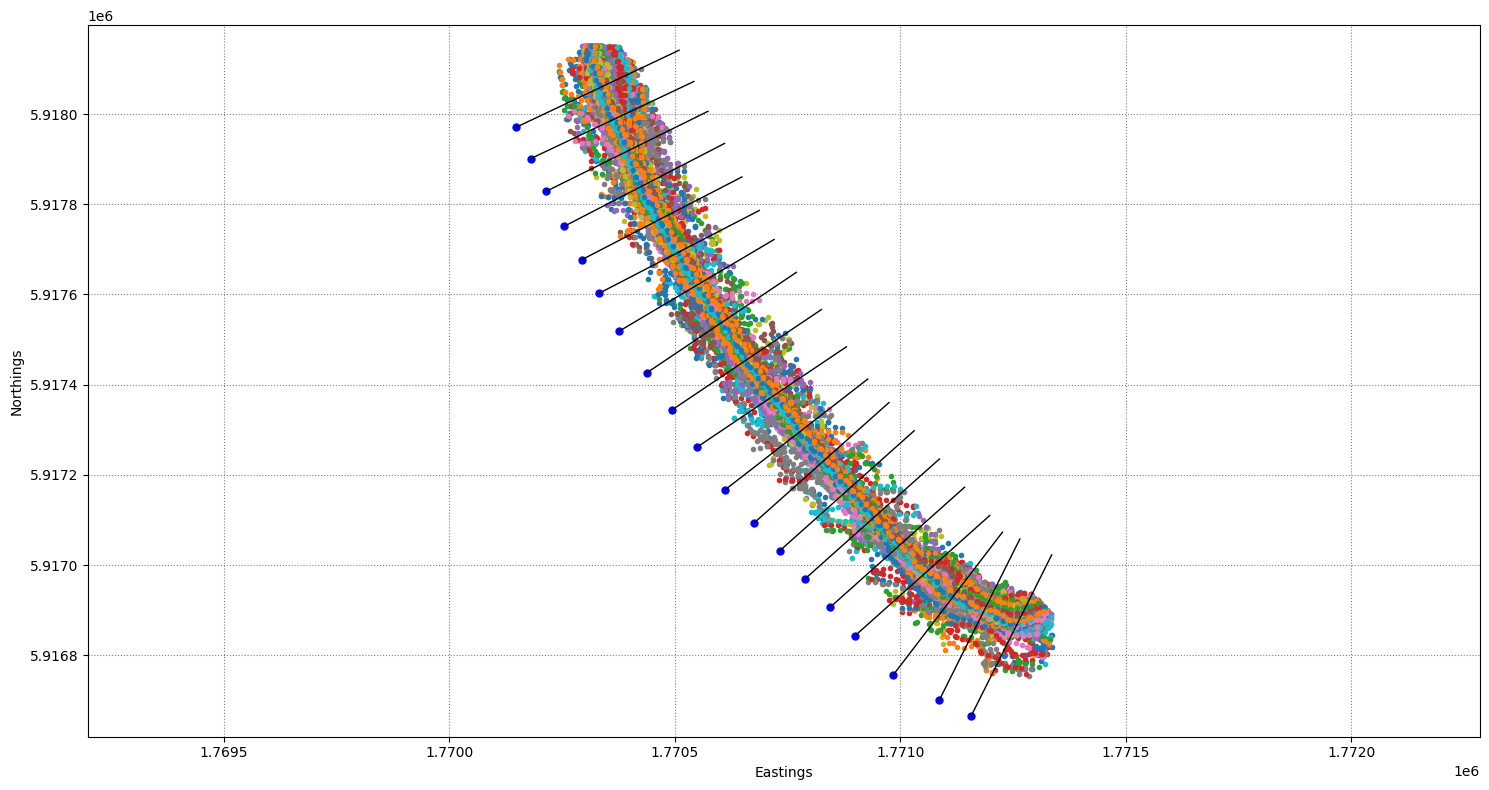

In [72]:
plt.ioff()
fig = plt.figure(figsize=[15,8], tight_layout=True)
plt.axis('equal')
plt.xlabel('Eastings')
plt.ylabel('Northings')
plt.grid(linestyle=':', color='0.5')
for i in range(len(output['shorelines'])):
    sl = output['shorelines'][i]
    date = output['dates'][i]
    plt.plot(sl[:,0], sl[:,1], '.', label=date.strftime('%d-%m-%Y'),lw=.1)
for i,key in enumerate(list(transects.keys())):
    plt.plot(transects[key][0,0],transects[key][0,1], 'bo', ms=5)
    plt.plot(transects[key][:,0],transects[key][:,1],'k-',lw=1)
    #plt.text(transects[key][0,0], transects[key][0,1], key.replace(f"{sitename}-0", ""),
    #            va='center', ha='center', bbox=dict(boxstyle="square", ec='k',fc='w'))
plt.show()

In [73]:
settings_transects = { # parameters for computing intersections
                      'along_dist':          25,        # along-shore distance to use for computing the intersection
                      'min_points':          3,         # minimum number of shoreline points to calculate an intersection
                      'max_std':             15,        # max std for points around transect
                      'max_range':           30,        # max range for points around transect
                      'min_chainage':        -100,      # largest negative value along transect (landwards of transect origin)
                      'multiple_inter':      'auto',    # mode for removing outliers ('auto', 'nan', 'max')
                      'auto_prc':            0.1,       # percentage of the time that multiple intersects are present to use the max
                     }
cross_distance = SDS_transects.compute_intersection_QC(output, transects, settings_transects) 

Computing transect shoreline intersections:   0%|          | 0/19 [00:00<?, ?it/s]

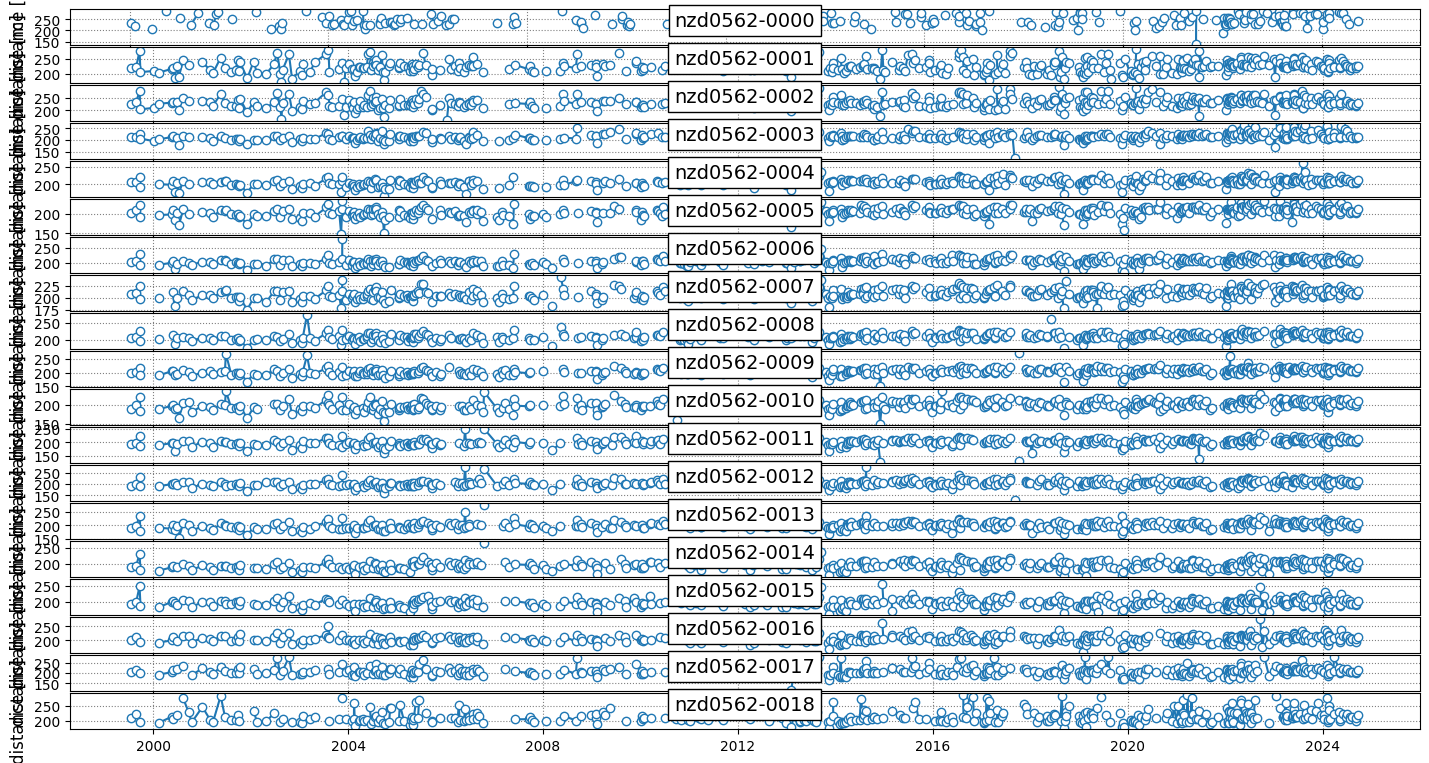

In [74]:
fig = plt.figure(figsize=[15,8], tight_layout=True)
gs = gridspec.GridSpec(len(cross_distance),1)
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.05)
for i,key in enumerate(cross_distance.keys()):
    if np.all(np.isnan(cross_distance[key])):
        continue
    ax = fig.add_subplot(gs[i,0])
    ax.grid(linestyle=':', color='0.5')
    ax.plot(output['dates'], cross_distance[key], '-o', ms=6, mfc='w')
    ax.set_ylabel('distance [m]', fontsize=12)
    ax.text(0.5,0.95, key, bbox=dict(boxstyle="square", ec='k',fc='w'), ha='center',
            va='top', transform=ax.transAxes, fontsize=14)
plt.show()

In [75]:
# save a .csv file for Excel users
out_dict = dict([])
out_dict['dates'] = output['dates']
out_dict["satname"] = output["satname"]
for key in transects.keys():
    out_dict[key] = cross_distance[key]
df = pd.DataFrame(out_dict)
fn = os.path.join(settings['inputs']['filepath'],settings['inputs']['sitename'],
                  'transect_time_series.csv')
df.to_csv(fn, sep=',')
#print('Time-series of the shoreline change along the transects saved as:\n%s'%fn)
df

dates satname  nzd0562-0000  nzd0562-0001  \
0   1999-07-18 21:58:49+00:00      L7           NaN    219.232852   
1   1999-08-26 22:04:44+00:00      L7           NaN    224.408533   
2   1999-09-20 21:58:56+00:00      L7           NaN    276.438786   
3   1999-09-27 22:05:12+00:00      L7           NaN    206.402610   
4   2000-01-10 21:58:52+00:00      L7    233.400052    210.182185   
..                        ...     ...           ...           ...   
597 2024-07-22 22:05:28+00:00      L9           NaN    224.075424   
598 2024-08-06 22:11:21+00:00      L8           NaN    221.072486   
599 2024-09-07 22:11:43+00:00      L8           NaN    220.160903   
600 2024-09-08 22:05:48+00:00      L9           NaN    225.518437   
601 2024-09-24 22:05:49+00:00      L9    240.799625    227.763689   

     nzd0562-0002  nzd0562-0003  nzd0562-0004  nzd0562-0005  nzd0562-0006  \
0      226.419241    213.028150    205.616075    201.118871    203.790358   
1      232.138518    214.709105    207.662985    207.930255    207.511467   
2      275.979793    226.639039    219.305047    221.979519    228.662079   
3      204.318087    206.456067    192.156081    192.588883    195.181155   
4      210.197070    195.252779           NaN           NaN           NaN   
..            ...           ...           ...           ...           ...   
597    222.559592    216.969398           NaN    201.737400    206.825267   
598    225.662035    211.063440    204.792840    202.749268    207.482405   
599    215.665830    210.341654    203.610938    200.970994    201.355967   
600    221.841104    213.289923    206.185990    203.948762    206.205069   
601    228.201386    214.397947    210.877242    211.656869    214.857432   

     nzd0562-0007  ...  nzd0562-0009  nzd0562-0010  nzd0562-0011  \
0      207.898691  ...    198.382218    190.517266    194.188475   
1      211.207061  ...    200.611986    200.433052    199.155382   
2      225.569955  ...    218.166233    220.713485    222.040560   
3      196.712667  ...    190.245704    185.277360    185.419868   
4             NaN  ...           NaN           NaN           NaN   
..            ...  ...           ...           ...           ...   
597    212.832507  ...    204.637381    199.147775    203.745499   
598    207.654325  ...    205.756605    204.626225    205.782044   
599    205.399940  ...    201.931198    196.303669    200.181027   
600    209.059124  ...    207.154053    202.006663    204.895037   
601    215.484717  ...    215.602528    210.767204    210.397537   

     nzd0562-0012  nzd0562-0013  nzd0562-0014  nzd0562-0015  nzd0562-0016  \
0      192.456067    188.754168    188.585684    192.967241    202.619218   
1      201.181179    196.575641    193.531931    199.308705    213.096401   
2      229.662276    236.006387    232.087103    249.025917           NaN   
3      192.582971    179.721132    179.074052    187.940017    194.544835   
4             NaN           NaN           NaN           NaN           NaN   
..            ...           ...           ...           ...           ...   
597    201.997532    196.898624    190.117196    193.850257    198.455336   
598    204.149502    199.340456    196.691397    193.513193    204.256725   
599    196.936953    190.609309    187.215212    190.300808    193.770537   
600    202.396365    198.637168    193.834581    191.727630    204.010103   
601    211.584259    207.798707    206.391607    202.293336    212.884617   

     nzd0562-0017  nzd0562-0018  
0      207.659021    207.907668  
1      214.562268    222.682325  
2             NaN           NaN  
3      199.010909    195.328019  
4             NaN           NaN  
..            ...           ...  
597    203.537910    204.410055  
598    206.157230    211.367635  
599    199.578055    198.800499  
600    205.149431    208.311908  
601    214.178571    217.714579  

[602 rows x 21 columns]